In [92]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *



processGens=ProcessGens()


process_gen_modes=["wmt_samples0"]
do_norm_analysis=True
processGens.init_with_mode(process_gen_modes)
root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = processGens.get_params()
compare_metric="BLEU_4"
examples_df, completions_df=get_dfs(processGens)

dfs_by_model={}
for model_name in examples_df['model'].unique():
    filtered_df = examples_df[examples_df["model"]==model_name]
    filtered_df["rank"]=100-filtered_df["example_idx"]
    dfs_by_model[model_name]=filtered_df

all_dfs_by_model=dfs_by_model

Init: process_gens_mode ['wmt_samples0']
calculate_gen_summary_dict
get_metrics_dict


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

Index(['example_comet', 'beam_num', 'task_name', 'model', 'example_idx',
       'suite', 'instanceID', 'text', 'completion_length', 'output_logprob',
       'isCompletion', 'BLEU_1', 'BLEU_4'],
      dtype='object')
Num examples: 100000
Num completions: 1000


In [93]:
print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

max_example_idx = examples_df["example_idx"].max()
plots_wide=1
num_models=len(dfs_by_model.keys())
plots_tall=math.ceil(num_models/plots_wide)

df=next(iter(dfs_by_model.values()))

	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [1] 
 	 models: ['meta_llama_Llama_3.1_8B_Instruct'] 
 	 custom_metrics['BLEU_1', 'BLEU_4']
 	 task_names ['wmt_14_language_pair_de_en_'] 
 	 suite_name sample_100_eval_1000 
 	 instance_metrics ['comet']
   example_comet  beam_num                    task_name  \
0       0.865341         1  wmt_14_language_pair_de_en_   
1       0.861965         1  wmt_14_language_pair_de_en_   

                              model  example_idx                 suite  \
0  meta_llama_Llama_3.1_8B_Instruct            0  sample_100_eval_1000   
1  meta_llama_Llama_3.1_8B_Instruct            1  sample_100_eval_1000   

   instanceID                                               text  \
0           0  He advised the parents of a boy whose penis ha...   
1           0  He advised the parents of a boy whose penis wa...   

   completion_length  output_logprob isCompletion    BLEU_1    BLEU_4  
0                178       -8.308031         True  0.71

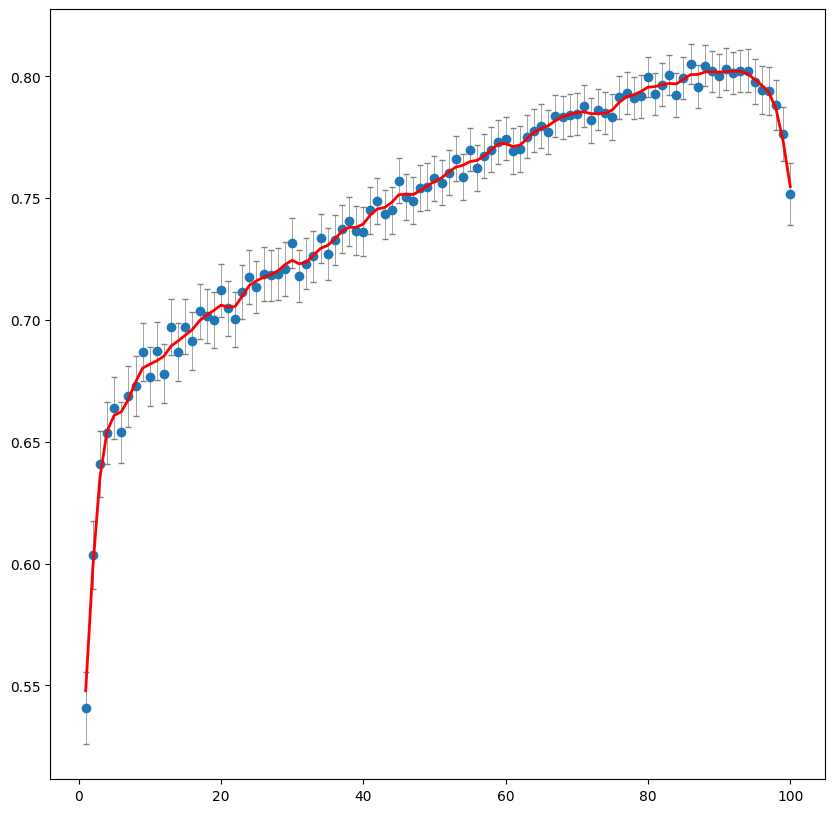

In [140]:
from scipy.interpolate import make_smoothing_spline
def plot_smooth_spline(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False):
    if(ax is None):
        _, ax = plt.subplots(figsize=(10, 10))
    warnings.simplefilter(action='ignore', category=FutureWarning)

    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
    

    yerr = grouped[(ylabel, 'std')].values
    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        yerr.append(1.96*s/math.sqrt(c))



    if(error_bar):
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=2, elinewidth=0.5, label='Data with std dev', zorder=00)
    else:
        ax.scatter(x,y)
    spl = make_smoothing_spline(x, y)
    ax.plot(x, spl(x), '-',linewidth=2, color="red", zorder=10)


plot_smooth_spline(df=df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title="", error_bar=True)